In [29]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from umap import umap_
from sklearn.metrics import silhouette_score
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.ndimage import gaussian_filter1d

---
---

# CLEANING

---

### DESCRIBE

In [30]:
df = pd.read_csv('data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [31]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

---

### clean

In [32]:
df['TotalCharges'] = df['TotalCharges'].replace({' ':'0'})
df['TotalCharges'] = df['TotalCharges'].astype(float)/df['tenure']

In [33]:
df = df.fillna(0.)

---

### DUMMIFY

In [34]:
to_replace = {
    'No' : 0,
    'Yes': 1
}

for c in ['Partner','Dependents','PhoneService', 'PaperlessBilling', 'Churn']:
    df[c] = df[c].map(to_replace)

In [35]:
to_replace = {
    'Female' : 0,
    'Male' : 1
}

df['gender'] = df['gender'].map(to_replace)

In [36]:
to_replace = {
    'No phone service': 0,
    'No': 1,
    'Yes': 2
}

df['MultipleLines'] = df['MultipleLines'].map(to_replace)

In [37]:
to_replace = {
    'DSL' : 1,
    'Fiber optic': 2,
    'No' : 0
}

df['InternetService'] = df['InternetService'].map(to_replace)

In [38]:
to_replace = {
    'No' : 0,
    'Yes': 1,
    'No internet service' : 0
}

for c in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[c] = df[c].map(to_replace)

In [39]:
to_replace = {
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
}

df['Contract'] = df['Contract'].map(to_replace)

In [40]:
df = pd.get_dummies(df, columns=['PaymentMethod'], prefix='PaymentMethod', drop_first=True, dtype=int)

---

### DIMENSIONAL REDUCTION AND CLUSTER

In [41]:
features = df.select_dtypes(include=['number'])

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

umap_reducer = umap_.UMAP(n_components=3, random_state=42)
umap_data = umap_reducer.fit_transform(normalized_data)

C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [42]:
dict_umap = { 
    'UMAP1' : umap_data[:,0],
    'UMAP2' : umap_data[:,1],
    'UMAP3' : umap_data[:,2],
    'churn' : df['Churn']
    }

df_umap = pd.DataFrame(dict_umap)

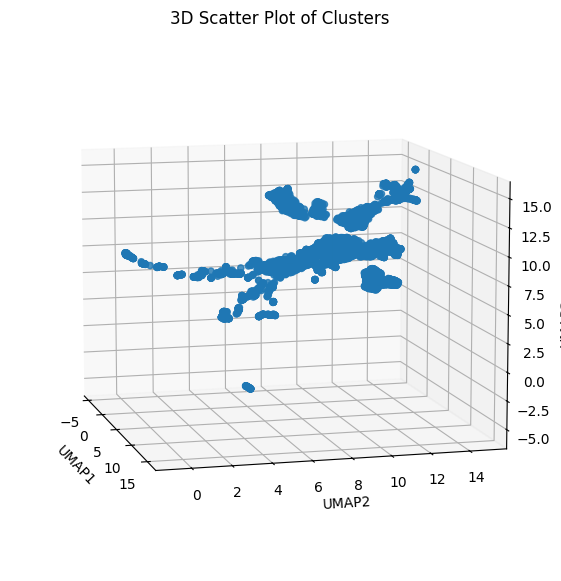

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_umap['UMAP1']  
y = df_umap['UMAP2']  
z = df_umap['UMAP3']

# Create the scatter plot
scatter = ax.scatter(x, y, z, s=20, alpha=0.8)

ax.view_init(elev=10, azim=-15)  

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.show()


In [44]:
clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clustering.fit_predict(df_umap[['UMAP1','UMAP2','UMAP3']])

df_umap['cluster'] = clustering.labels_

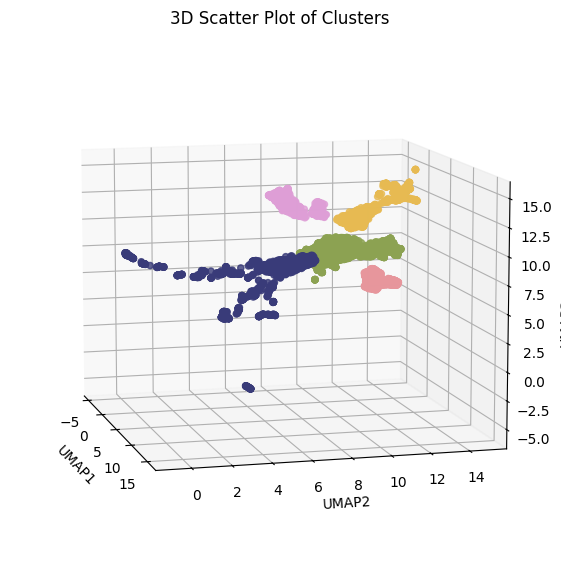

In [45]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_umap['UMAP1']  
y = df_umap['UMAP2']  
z = df_umap['UMAP3']  
labels = df_umap['cluster']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20b', s=20, alpha=0.8)

ax.view_init(elev=10, azim=-15)  

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.show()


In [46]:
X = features
y = df_umap['cluster'].astype(str)

# We create the LGBMClassifier model and train it
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf_km.fit(X=X, y=y)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 22
[LightGBM] [Info] Start training from score -1.590173
[LightGBM] [Info] Start training from score -0.917783
[LightGBM] [Info] Start training from score -1.783136
[LightGBM] [Info] Start training from score -2.334760
[LightGBM] [Info] Start training from score -2.026758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier(colsample_by_tree=0.8)

In [47]:
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km(X)

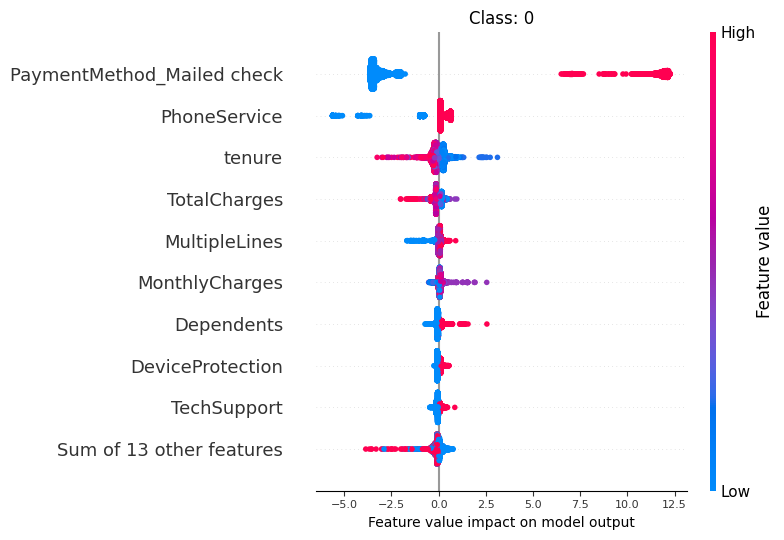

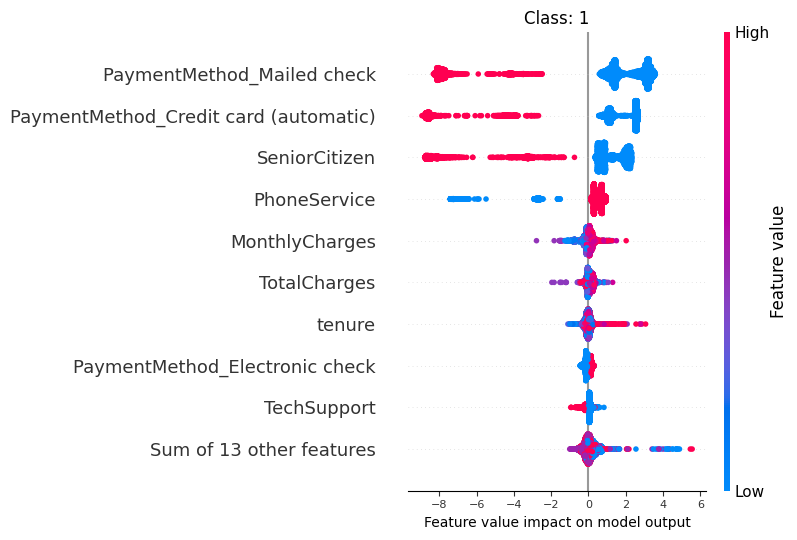

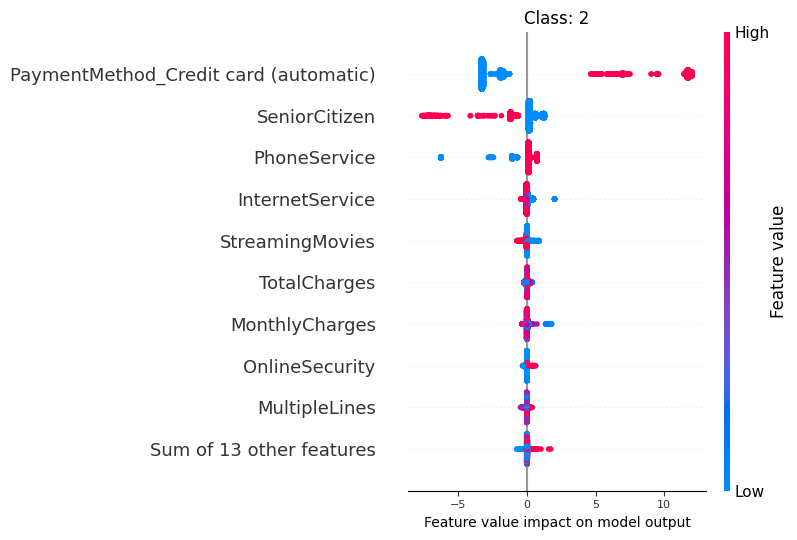

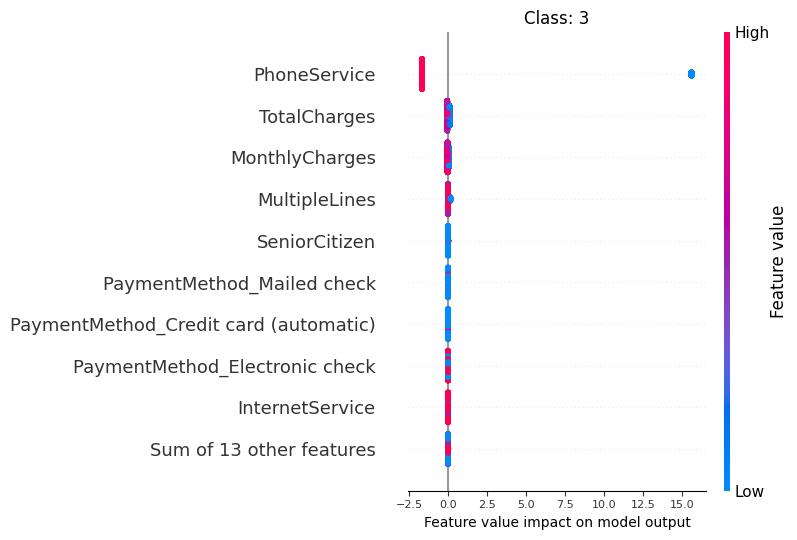

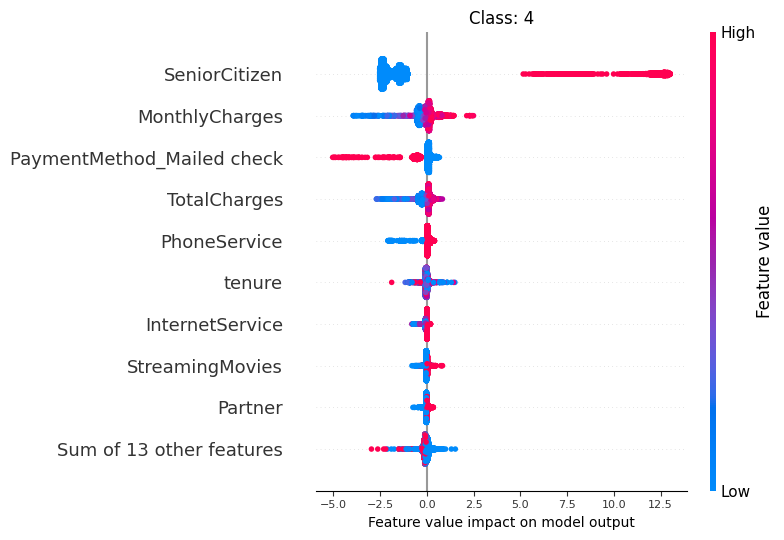

In [48]:
class_names = clf_km.classes_

for k in range(5):
    shap.plots.beeswarm(shap_values_km[:, :, k], show=False)
    ax = plt.gca()
    ax.set_title(f"Class: {class_names[k]}")

    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel("Feature value impact on model output", fontsize=10)
    plt.tight_layout()
    plt.show()


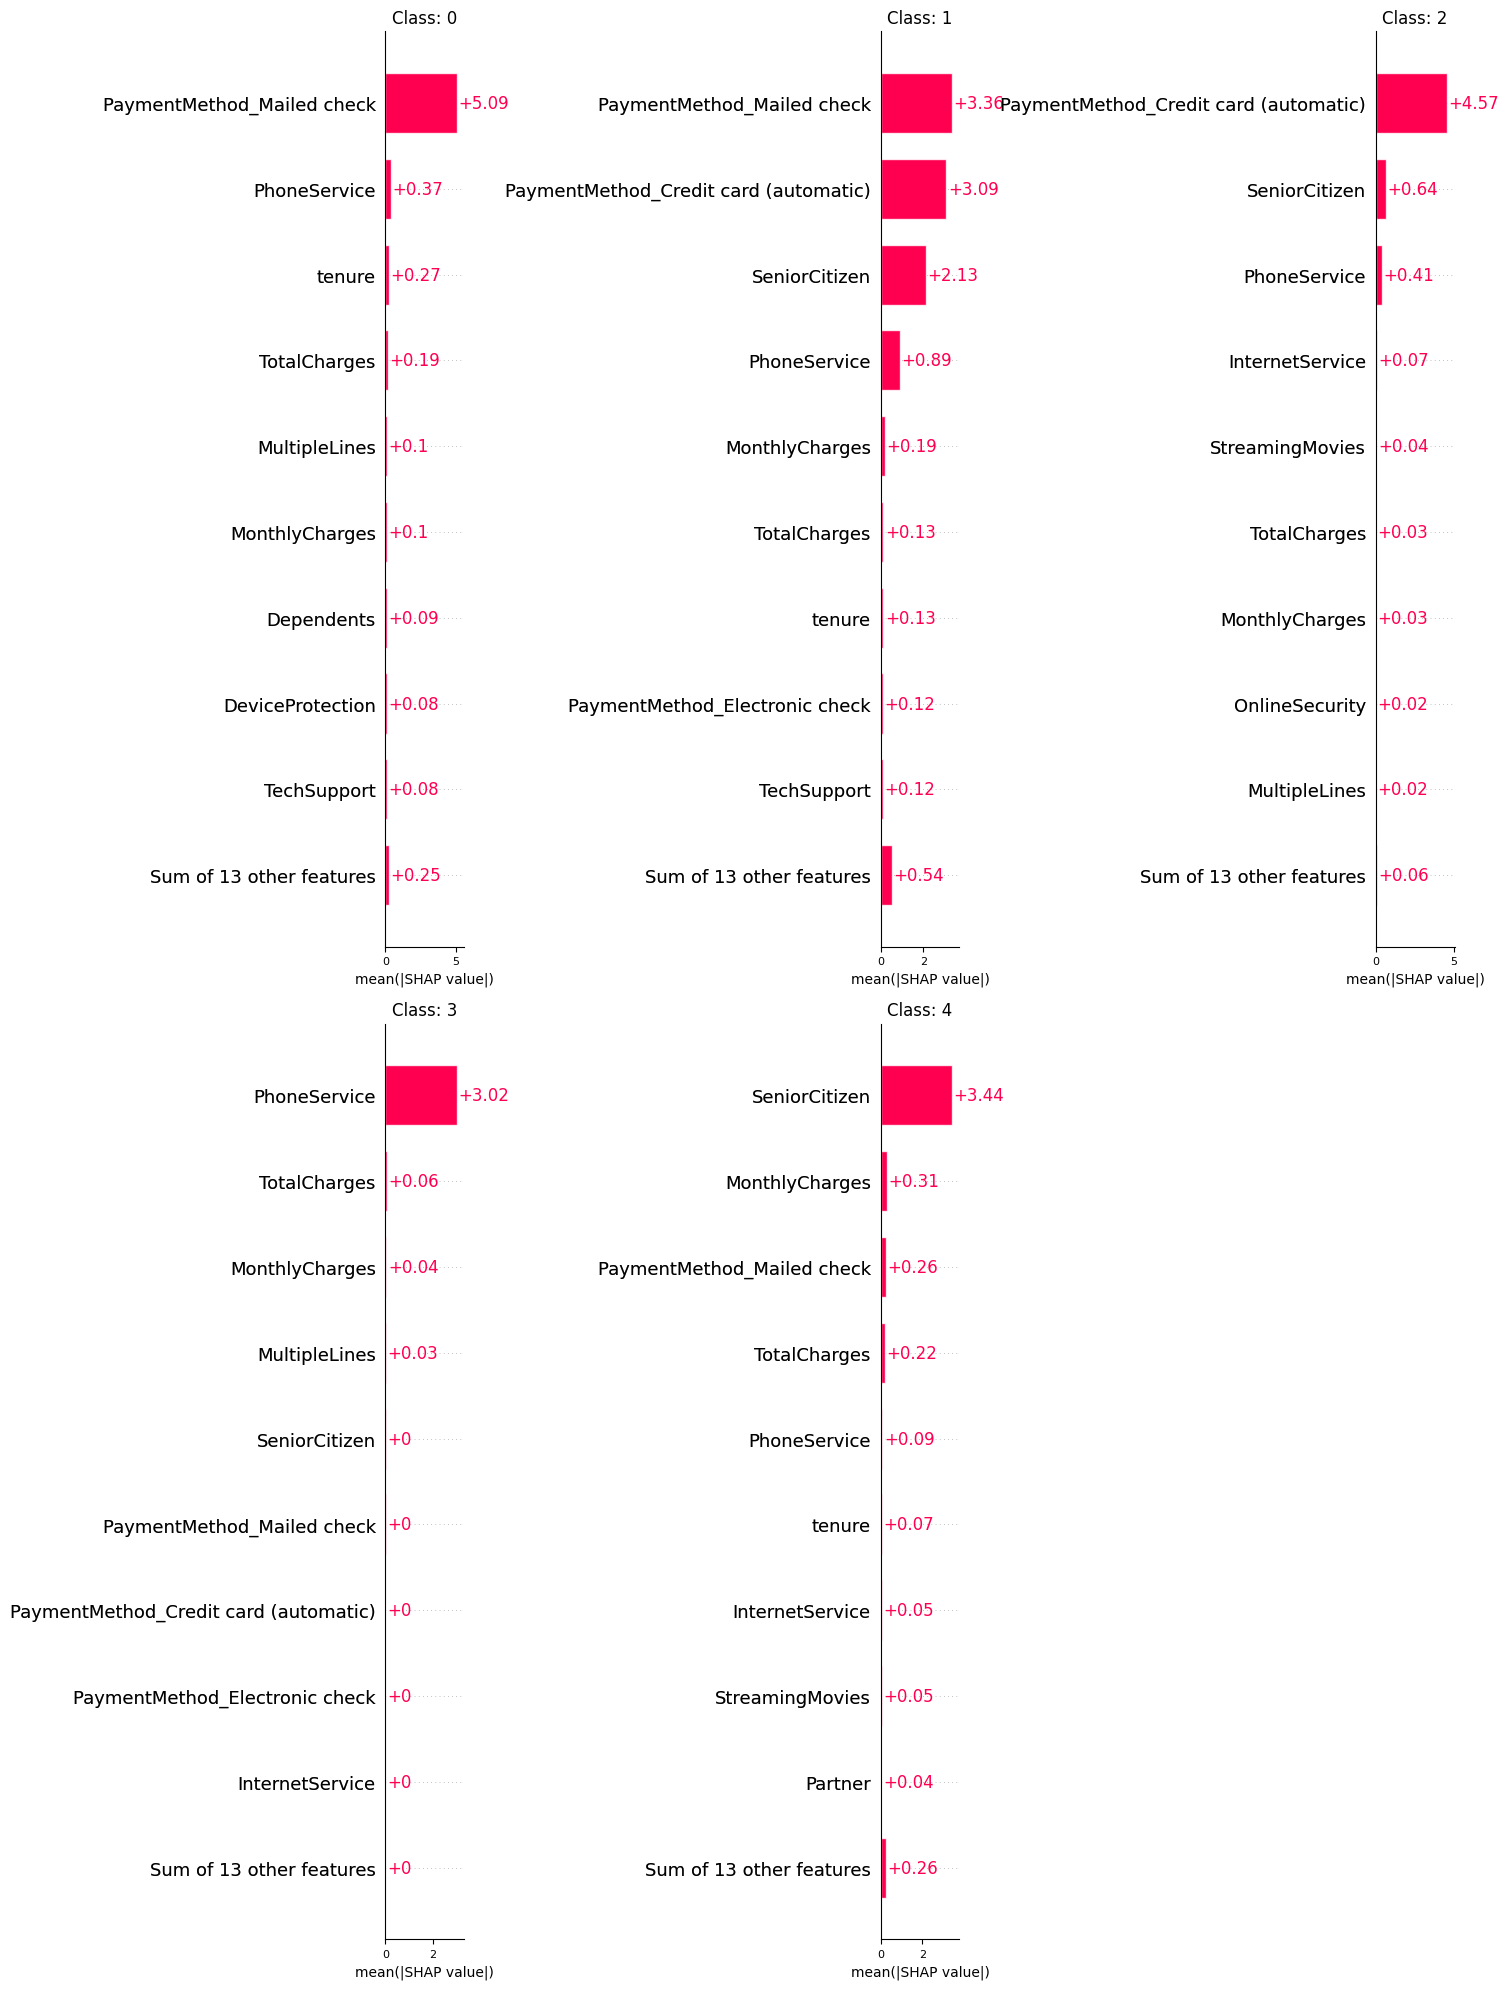

In [49]:
class_names = clf_km.classes_ 

fig, axes = plt.subplots(2, 3, figsize=(15, 20))  # Adjust figsize for readability
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < len(class_names):
        shap.plots.bar(shap_values_km[:, :, k], show=False, ax=ax)
        ax.set_title(f"Class: {class_names[k]}")

        ax.tick_params(axis='x', labelsize=8)
        ax.set_xlabel("mean(|SHAP value|)", fontsize=10)
    else:
        ax.axis('off')
        
plt.tight_layout()
plt.savefig('artifacts/imgs/shap.png', transparent=True, bbox_inches='tight')
plt.show()


In [50]:
features['cluster'] = df_umap['cluster']

cluster_names = {
    '0' : 'mail check payers',
    '1' : 'young electronic check payers',
    '2' : 'young credit card users',
    '3' : 'no phone service',
    '4' : 'senior high spenders'
}

features['cluster_name'] = features['cluster'].astype(str).replace(cluster_names)
df_umap['cluster_name'] = features['cluster_name']

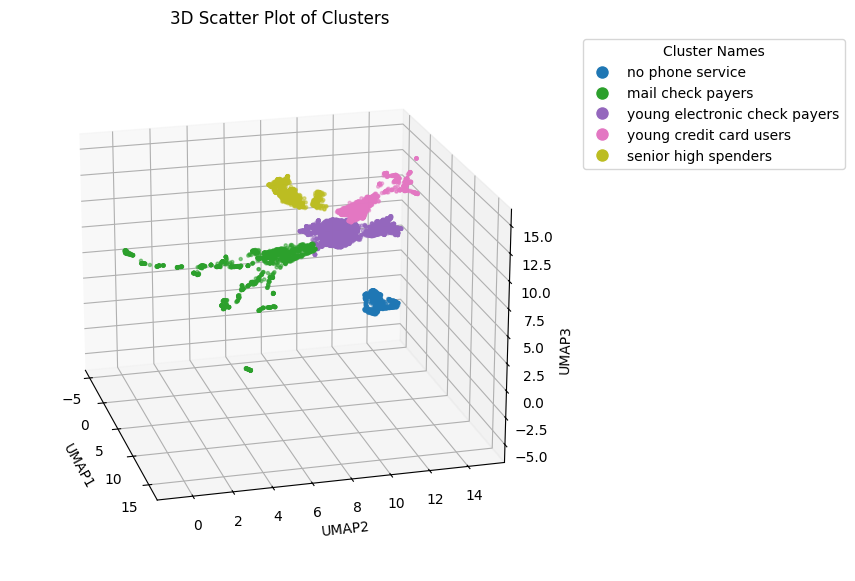

In [75]:
# Assuming df_sampled is already defined and contains the necessary columns
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_umap['UMAP1']  
y = df_umap['UMAP2']  
z = df_umap['UMAP3']  
labels = df_umap['cluster']  # This contains the cluster number for each point
cluster_names = df_umap['cluster_name'].unique()  # Extract unique cluster names

# Use the same colormap
cmap = plt.cm.tab20

# Plot each cluster separately
handles = []
for i, cluster_name in enumerate(cluster_names):
    # Filter the data for the current cluster
    cluster_data = df_umap[df_umap['cluster_name'] == cluster_name]
    
    # Assign a specific color to the cluster
    color = cmap((i) / len(cluster_names))
    
    # Plot the cluster points
    ax.scatter(
        cluster_data['UMAP1'], 
        cluster_data['UMAP2'], 
        cluster_data['UMAP3'], 
        c=[color], 
        label=cluster_name, 
        s=5, 
        alpha=0.5
    )
    
    # Add to legend handles
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cluster_name)
    handles.append(handle)

ax.view_init(elev=20, azim=-15)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Add the legend with the custom handles
ax.legend(handles=handles, title="Cluster Names", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save and show the plot
plt.savefig('artifacts/imgs/clustering.png', transparent=True, bbox_inches='tight')
plt.show()

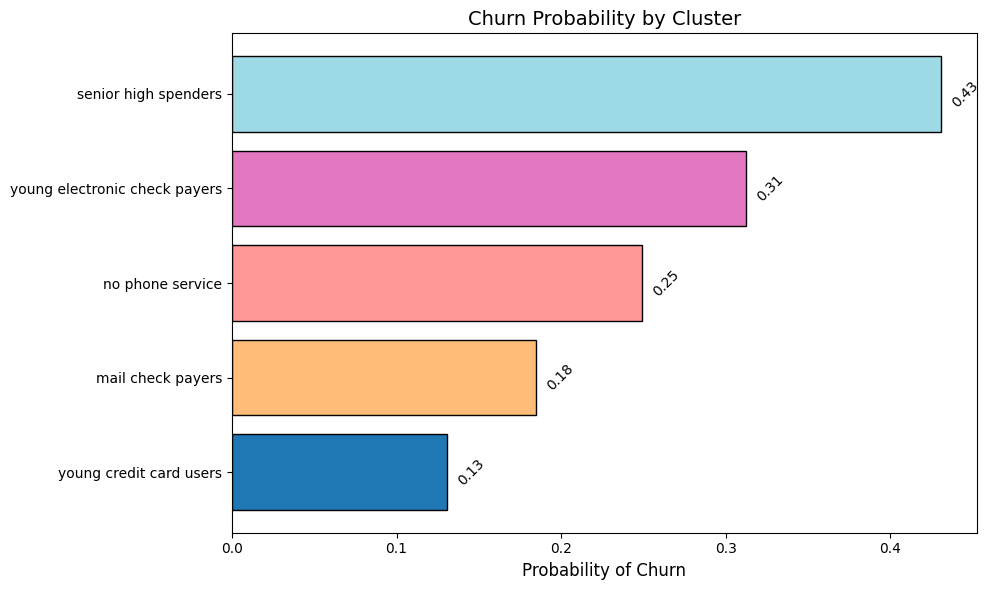

In [52]:
cluster_churn_probabilities = features.groupby('cluster_name')['Churn'].mean()
churn_prob_sorted = cluster_churn_probabilities.sort_values(ascending=True)

norm = plt.Normalize(churn_prob_sorted.min(), churn_prob_sorted.max())
colors = plt.cm.tab20(norm(churn_prob_sorted))  # Using the "viridis" colormap

plt.figure(figsize=(10, 6))
bars = plt.barh(churn_prob_sorted.index, churn_prob_sorted, color=colors, edgecolor='black')

# Add values at the end of bars
for bar, value in zip(bars, churn_prob_sorted):
    plt.text(value + 0.005, bar.get_y() + bar.get_height() / 2,
             f'{value:.2f}', va='center', fontsize=10, rotation=45)

# Customizing the plot
plt.xlabel('Probability of Churn', fontsize=12)
plt.title('Churn Probability by Cluster', fontsize=14)
plt.tight_layout()

plt.savefig('artifacts/imgs/cluster_churn_probabilities.png', transparent=True)

# Show the plot
plt.show()


---
---

# CHURN PREDICTION

In [53]:
X = features.drop(['Churn','cluster','cluster_name'],axis=1)
y = features['Churn']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

### LOGISTIC REGRESSION

In [55]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.59      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.76      1409
weighted avg       0.81      0.82      0.81      1409

AUC-ROC: 0.860653213535251


In [56]:
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

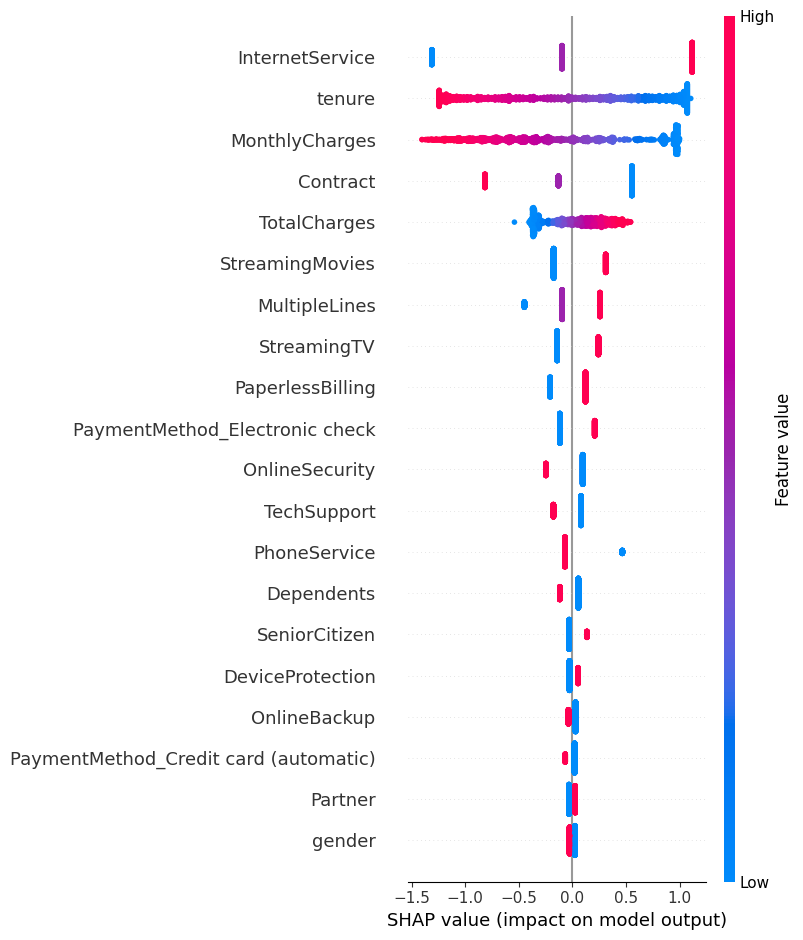

In [57]:
shap.summary_plot(shap_values, X_test)

---

### XGBoost

In [58]:
# Train XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.62      0.50      0.55       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

AUC-ROC: 0.8356226774457338


In [59]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}
grid = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [60]:
# Train XGBoost
xgb = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50)
xgb.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409

AUC-ROC: 0.8632707774798927


In [61]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

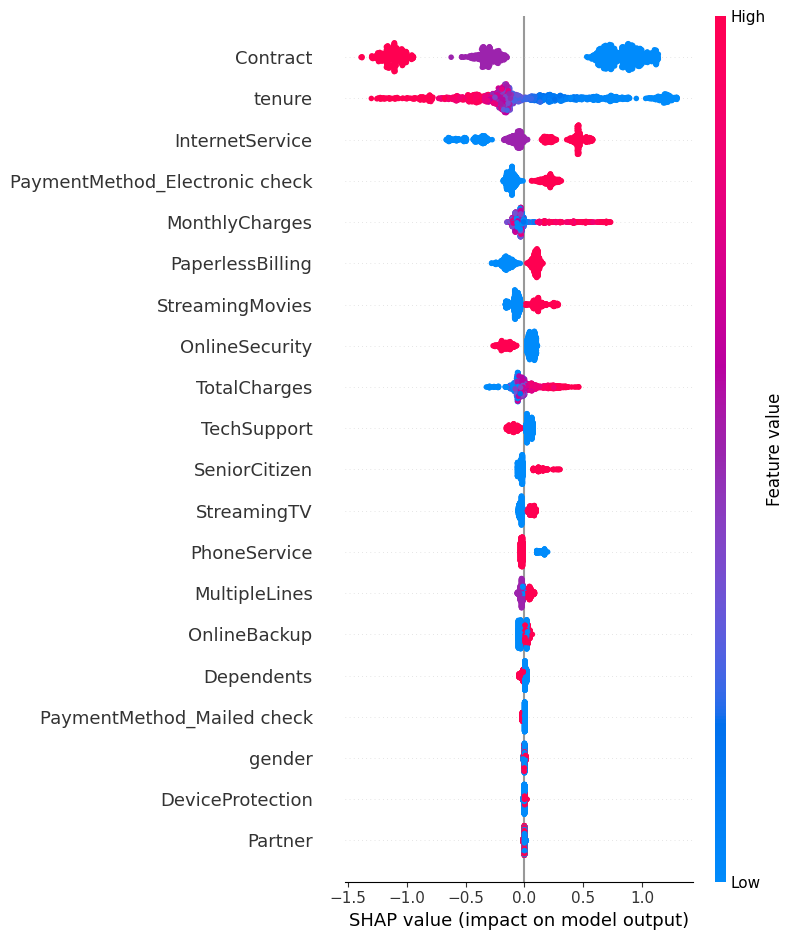

In [62]:
shap.summary_plot(shap_values, X_test)

---

### RANDOM FOREST

In [63]:
rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_rf))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1036
           1       0.70      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.80      0.81      0.79      1409

AUC-ROC: 0.865149523326467


In [64]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  # Use AUC-ROC as the evaluation metric
    cv=5,              # 5-fold cross-validation
    verbose=1,          # Display progress
    n_jobs=-1           # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best AUC-ROC score:", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 7, 'n_estimators': 200}
Best AUC-ROC score: 0.8413559121642841


In [65]:
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_rf))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1036
           1       0.70      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.77      0.70      0.72      1409
weighted avg       0.80      0.81      0.80      1409

AUC-ROC: 0.8651779891726272


---
---

# CHURN CURVES

In [66]:
churned_percentage = (
    features.groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)

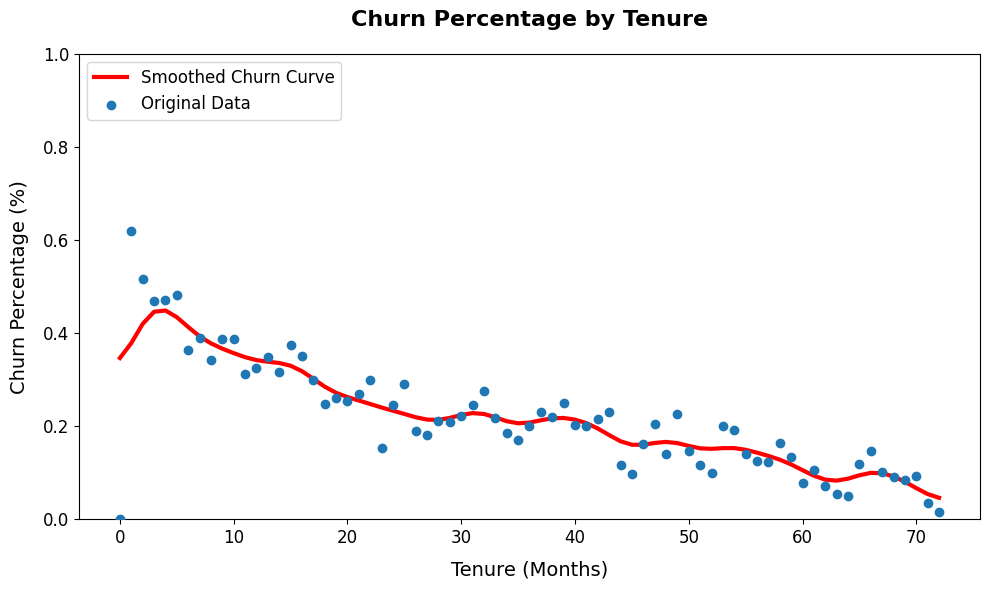

In [67]:
plt.figure(figsize=(10, 6))

# Smoothed line
smoothed_churn = gaussian_filter1d(churned_percentage['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage['tenure'], smoothed_churn, label='Smoothed Churn Curve', color='red', linewidth=3)

# Scatter points for original data
plt.scatter(churned_percentage['tenure'], churned_percentage['Churn_Percentage'], 
            color='C0', label='Original Data', zorder=3)

# Title and labels with styling
plt.title('Churn Percentage by Tenure', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tenure (Months)', fontsize=14, labelpad=10)
plt.ylabel('Churn Percentage (%)', fontsize=14, labelpad=10)

# Set y-axis range to make it visually clearer
plt.ylim(0, 1)

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()

plt.savefig('artifacts/imgs/churn_curve.png', transparent=True)

plt.show()


In [68]:
churned_percentage_no_internet = (
    features.loc[features['InternetService']==0].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)

churned_percentage_DSL = (
    features.loc[features['InternetService']==1].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)

churned_percentage_Fiber = (
    features.loc[features['InternetService']==2].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)


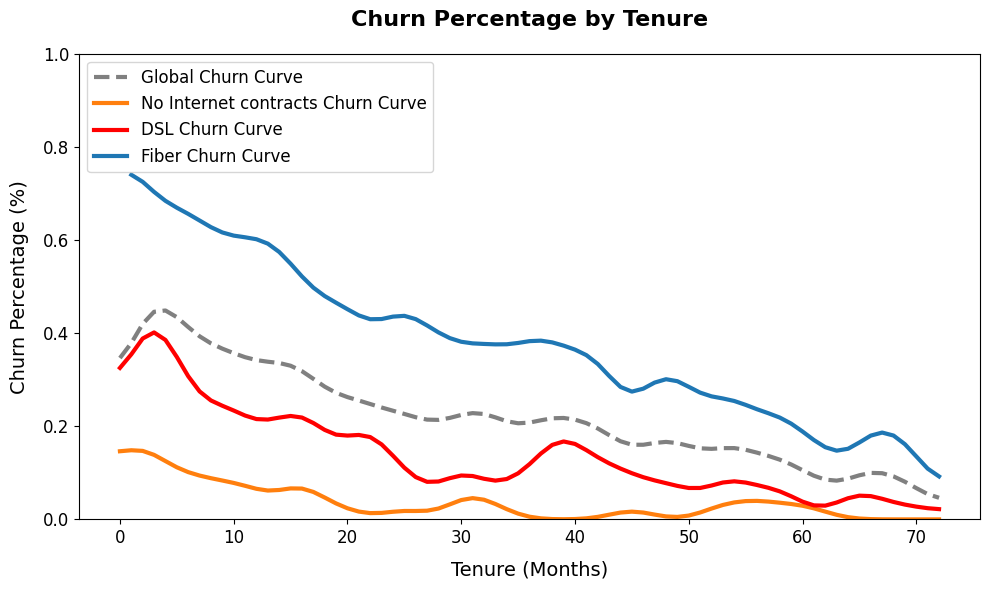

In [69]:
plt.figure(figsize=(10, 6))

# Smoothed line
smoothed_churn = gaussian_filter1d(churned_percentage['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage['tenure'], smoothed_churn, label='Global Churn Curve', color='gray', linewidth=3, ls='dashed')

smoothed_churn = gaussian_filter1d(churned_percentage_no_internet['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_no_internet['tenure'], smoothed_churn, label='No Internet contracts Churn Curve', color='C1', linewidth=3)

smoothed_churn = gaussian_filter1d(churned_percentage_DSL['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_DSL['tenure'], smoothed_churn, label='DSL Churn Curve', color='red', linewidth=3)

smoothed_churn = gaussian_filter1d(churned_percentage_Fiber['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_Fiber['tenure'], smoothed_churn, label='Fiber Churn Curve', color='C0', linewidth=3)


# Title and labels with styling
plt.title('Churn Percentage by Tenure', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tenure (Months)', fontsize=14, labelpad=10)
plt.ylabel('Churn Percentage (%)', fontsize=14, labelpad=10)

# Set y-axis range to make it visually clearer
plt.ylim(0, 1)

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()

plt.savefig('artifacts/imgs/churn_curve_internet.png', transparent=True)

plt.show()


In [70]:
churned_percentage_month = (
    features.loc[features['Contract']==0].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)

churned_percentage_1year = (
    features.loc[features['Contract']==1].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)

churned_percentage_2year = (
    features.loc[features['Contract']==2].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)


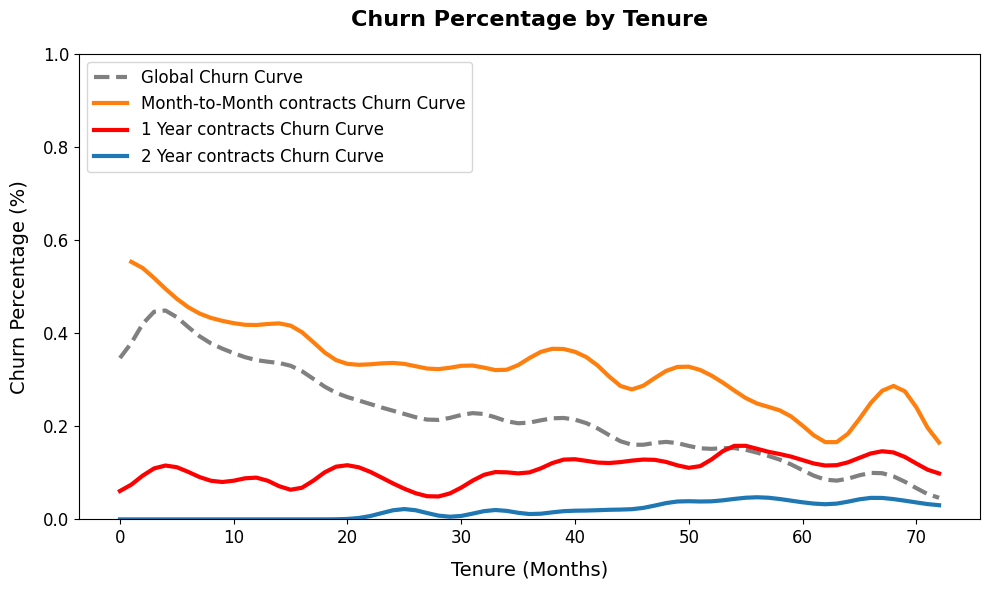

In [71]:
plt.figure(figsize=(10, 6))

# Smoothed line
smoothed_churn = gaussian_filter1d(churned_percentage['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage['tenure'], smoothed_churn, label='Global Churn Curve', color='gray', linewidth=3, ls='dashed')

smoothed_churn = gaussian_filter1d(churned_percentage_month['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_month['tenure'], smoothed_churn, label='Month-to-Month contracts Churn Curve', color='C1', linewidth=3)

smoothed_churn = gaussian_filter1d(churned_percentage_1year['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_1year['tenure'], smoothed_churn, label='1 Year contracts Churn Curve', color='red', linewidth=3)

smoothed_churn = gaussian_filter1d(churned_percentage_2year['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_2year['tenure'], smoothed_churn, label='2 Year contracts Churn Curve', color='C0', linewidth=3)


# Title and labels with styling
plt.title('Churn Percentage by Tenure', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tenure (Months)', fontsize=14, labelpad=10)
plt.ylabel('Churn Percentage (%)', fontsize=14, labelpad=10)

# Set y-axis range to make it visually clearer
plt.ylim(0, 1)

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()

plt.savefig('artifacts/imgs/churn_curve_contract.png', transparent=True)

plt.show()


In [72]:
churned_percentage_senior = (
    features.loc[features['SeniorCitizen']==1].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)

churned_percentage_young = (
    features.loc[features['SeniorCitizen']==0].groupby('tenure')['Churn']
    .mean()
    .reset_index()
    .rename(columns={'Churn': 'Churn_Percentage'})
)


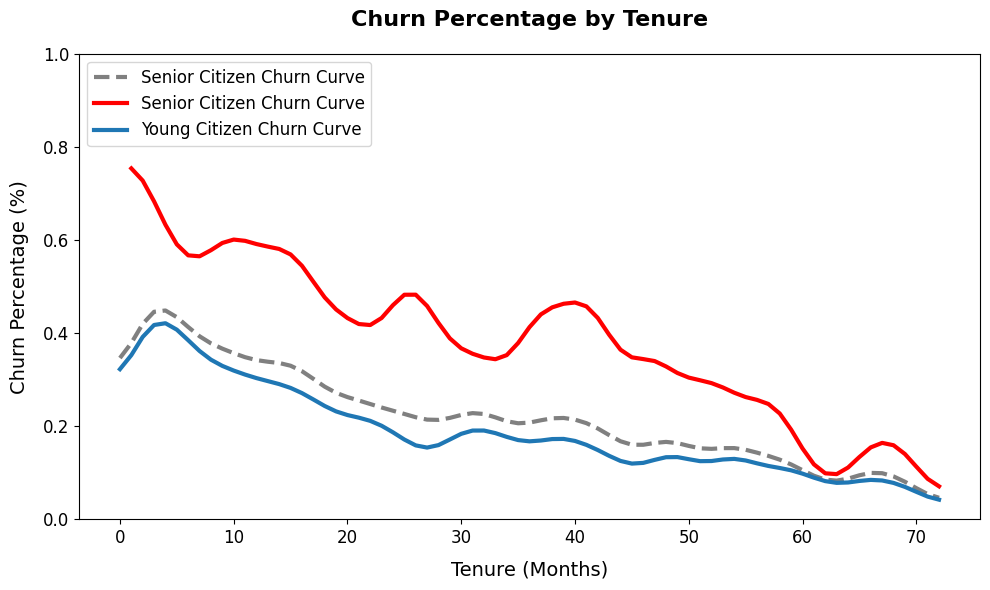

In [73]:
plt.figure(figsize=(10, 6))

# Smoothed line
smoothed_churn = gaussian_filter1d(churned_percentage['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage['tenure'], smoothed_churn, label='Senior Citizen Churn Curve', color='gray', linewidth=3, ls='dashed')


smoothed_churn = gaussian_filter1d(churned_percentage_senior['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_senior['tenure'], smoothed_churn, label='Senior Citizen Churn Curve', color='red', linewidth=3)

smoothed_churn = gaussian_filter1d(churned_percentage_young['Churn_Percentage'], sigma=2)
plt.plot(churned_percentage_young['tenure'], smoothed_churn, label='Young Citizen Churn Curve', color='C0', linewidth=3)


# Title and labels with styling
plt.title('Churn Percentage by Tenure', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tenure (Months)', fontsize=14, labelpad=10)
plt.ylabel('Churn Percentage (%)', fontsize=14, labelpad=10)

# Set y-axis range to make it visually clearer
plt.ylim(0, 1)

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()

plt.savefig('artifacts/imgs/churn_curve_senior.png', transparent=True)

plt.show()
